In [1]:
import torch
import torch, torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import ConfusionMatrix
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.model import cnn 
from medmnist import INFO, TissueMNIST, PathMNIST

In [2]:
@torch.no_grad()
def eval_func_extended(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
    class_names=None  
):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_logits = []
    all_preds  = []
    all_targets = []

    for X, y in data_loader:
        y = y.squeeze().long()              #MedMNIST Labels [N,1] -> [N]
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        bs = X.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        preds = logits.argmax(dim=1)

        all_logits.append(logits.detach().cpu())
        all_preds.append(preds.detach().cpu())
        all_targets.append(y.detach().cpu())

    all_logits = torch.cat(all_logits)
    all_preds  = torch.cat(all_preds).numpy()
    all_targets= torch.cat(all_targets).numpy()

    avg_loss = total_loss / total_samples

    # Metriken (macro & weighted)
    acc = accuracy_score(all_targets, all_preds) * 100.0
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="macro", zero_division=0
    )
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="weighted", zero_division=0
    )

    report = classification_report(
        all_targets, all_preds,
        target_names=class_names if class_names else None,
        digits=3, zero_division=0,
        output_dict=True
    )

    # Softmax-Wahrscheinlichkeiten
    probs = F.softmax(all_logits, dim=1).numpy()

    results = {
        "model_name": model.__class__.__name__,
        "loss": avg_loss,
        "accuracy_percent": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "predictions": all_preds,
        "targets": all_targets,
        "probs": probs,
        "report": report
    }
    return results

In [4]:
dataset_name = "pathmnist"
info = INFO[dataset_name]
n_classes, n_channels = len(info["label"]), info["n_channels"]

# Kanalabhängige Transforms & Loader
if n_channels == 1:
    mean, std, as_rgb = [0.5], [0.5], False
else:
    mean, std, as_rgb = [0.5,0.5,0.5], [0.5,0.5,0.5], True

IMG_SIZE = 64
test_tf = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(mean, std)])
TestClass = TissueMNIST if dataset_name=="tissuemnist" else PathMNIST
test_set = TestClass(split="test", download=True, transform=test_tf, as_rgb=as_rgb)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn(input_shape=n_channels, hidden_units=16, output_shape=n_classes).to(device)
model.load_state_dict(torch.load("best_pathmnist_cnn.pt", map_location=device))

loss_fn = torch.nn.CrossEntropyLoss()
class_names = [str(k) for k in range(n_classes)]  

results = eval_func_extended(model, test_loader, loss_fn, device, class_names=class_names)
results

{'model_name': 'cnn',
 'loss': 0.9149506011879212,
 'accuracy_percent': 75.59888579387186,
 'precision_macro': 0.74260896837046,
 'recall_macro': 0.7397717574167003,
 'f1_macro': 0.7225338749512513,
 'precision_weighted': 0.7964640444112929,
 'recall_weighted': 0.7559888579387186,
 'f1_weighted': 0.758720481049729,
 'predictions': array([8, 4, 4, ..., 6, 8, 8], shape=(7180,)),
 'targets': array([8, 4, 4, ..., 4, 8, 8], shape=(7180,)),
 'probs': array([[1.56219437e-06, 2.25867028e-04, 7.46078804e-05, ...,
         1.87834222e-02, 7.62013078e-05, 9.53324378e-01],
        [1.94133108e-03, 4.22272511e-04, 2.50102137e-04, ...,
         3.94209921e-02, 9.16626013e-04, 2.43947595e-01],
        [1.99830346e-02, 1.38514163e-03, 5.76805576e-07, ...,
         1.49008827e-02, 4.76985952e-06, 1.21239354e-04],
        ...,
        [7.95417989e-04, 1.60963355e-05, 2.61565583e-06, ...,
         6.09426618e-01, 2.12279429e-05, 1.81639066e-03],
        [5.62079890e-07, 4.55795816e-06, 8.22056063e-06, ..

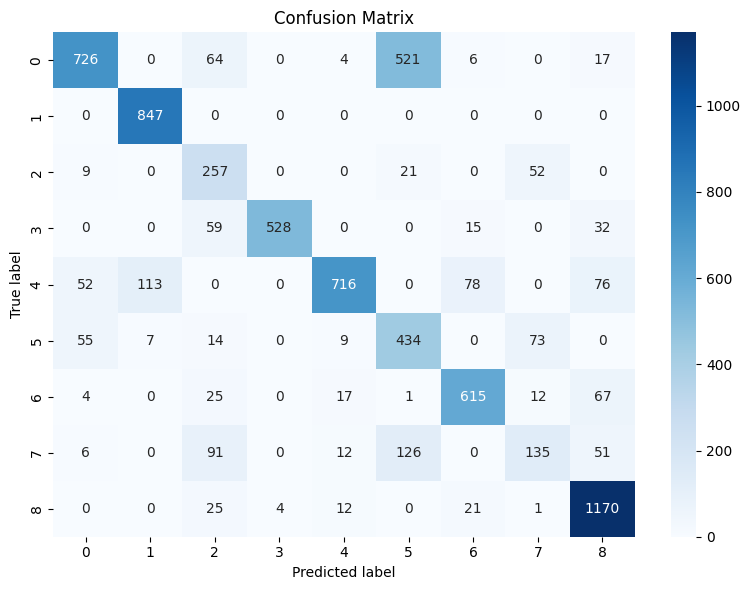

In [5]:
cm_metric = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
cm_tensor = cm_metric(
    preds=torch.tensor(results["predictions"]),
    target=torch.tensor(results["targets"])
).numpy()

plt.figure(figsize=(8,6))
sns.heatmap(cm_tensor, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

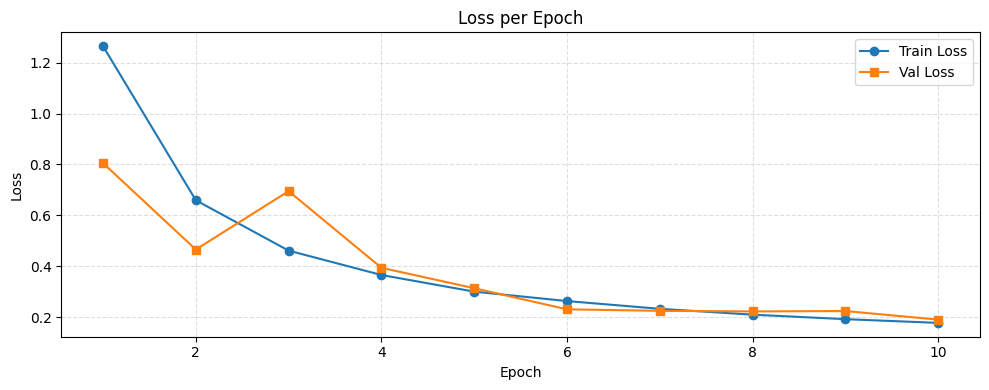

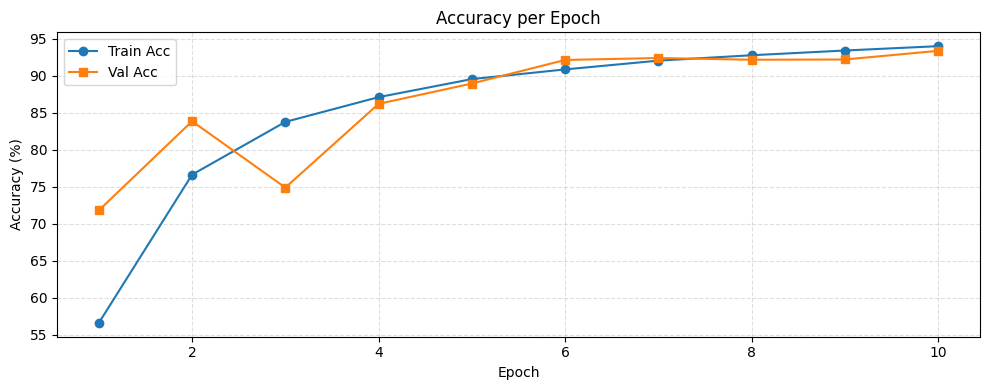

In [6]:
data = np.load("logs_pathmnist_iter.npz", allow_pickle=True)

epoch_train_loss = data["epoch_train_loss"]
epoch_val_loss   = data["epoch_val_loss"]
epoch_train_acc  = data["epoch_train_acc"]
epoch_val_acc    = data["epoch_val_acc"]

epochs = np.arange(1, len(epoch_train_loss) + 1)

# Loss pro Epoche
plt.figure(figsize=(10,4))
plt.plot(epochs, epoch_train_loss, label="Train Loss", marker="o")
plt.plot(epochs, epoch_val_loss,   label="Val Loss",   marker="s")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per Epoch")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout()
plt.show()

# Accuracy pro Epoche
plt.figure(figsize=(10,4))
plt.plot(epochs, epoch_train_acc, label="Train Acc", marker="o")
plt.plot(epochs, epoch_val_acc,   label="Val Acc",   marker="s")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy per Epoch")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout()
plt.show()